In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install shimmy
!pip install gymnasium stable-baselines3
!pip install torch_geometric

  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.0.0a2
    Uninstalling gymnasium-1.0.0a2:
      Successfully uninstalled gymnasium-1.0.0a2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shimmy 2.0.0 requires gymnasium>=1.0.0a1, but you have gymnasium 0.29.1 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the data and parse the date-time column
df = pd.read_csv('/content/drive/MyDrive/MAHE/Project/stocks_with_features_and_target_returns.csv', parse_dates=['Date'])

# Convert the date-time to a numeric value
df['Date'] = df['Date'].map(lambda x: x.timestamp())

# Fill missing values (you can choose other methods as appropriate)
df.fillna(method='ffill', inplace=True)

# Normalize the data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.drop(columns=['Date'])), columns=df.columns[1:])
df_scaled['Date'] = df['Date'].values


<ipython-input-3-09b4f813d32c>:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, BatchNorm, GATConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the data
df = pd.read_csv('/content/drive/MyDrive/MAHE/Project/stocks_with_features_and_target_returns.csv')

# Define tickers and features
tickers = [col.split('_')[0] for col in df.columns if '_target_returns' in col]
features = [col for col in df.columns if '_Close' in col]  # Add more features here (e.g., technical indicators)
target = [f'{ticker}_target_returns' for ticker in tickers]

# Preprocess the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])
target_returns = df[target].values

# Create graph data (example with fully connected graph)
edge_index = torch.tensor([[i, j] for i in range(len(tickers)) for j in range(len(tickers))], dtype=torch.long).t().contiguous()

# Create PyTorch geometric data object
data = Data(x=torch.tensor(scaled_features, dtype=torch.float), edge_index=edge_index)

# Define the advanced GNN model
class GNNPortfolio(nn.Module):
    def __init__(self, num_features, num_assets):
        super(GNNPortfolio, self).__init__()
        self.conv1 = GATConv(num_features, 128, heads=4, concat=True)
        self.bn1 = BatchNorm(128 * 4)
        self.conv2 = GATConv(128 * 4, 64, heads=4, concat=True)
        self.bn2 = BatchNorm(64 * 4)
        self.fc1 = nn.Linear(64 * 4, 32)
        self.fc2 = nn.Linear(32, num_assets)
        self.dropout = nn.Dropout(0.3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Custom Sharpe Ratio Loss Function
class SharpeLoss(nn.Module):
    def __init__(self):
        super(SharpeLoss, self).__init__()

    def forward(self, predicted_returns, actual_returns):
        mean_return = torch.mean(predicted_returns, axis=0)
        return_std = torch.std(predicted_returns, axis=0) + 1e-8  # Prevent division by zero
        sharpe_ratio = mean_return / return_std
        return -torch.mean(sharpe_ratio)  # Maximize Sharpe Ratio by minimizing negative Sharpe

# Initialize the model, custom loss function, and optimizer
model = GNNPortfolio(num_features=scaled_features.shape[1], num_assets=len(tickers))
criterion = SharpeLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=5e-4)

# Implement cyclical learning rate
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=10, mode='triangular2')

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target_returns, test_size=0.2, random_state=42)

# Convert to torch tensors
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=edge_index)
test_data = Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=edge_index)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

# Training loop with advanced modifications
epochs = 150
best_sharpe = float('-inf')
patience, trials = 30, 0

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(train_data)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    # Update learning rate with scheduler
    scheduler.step()

    # Early stopping based on Sharpe Ratio
    model.eval()
    with torch.no_grad():
        predicted_returns = model(test_data).numpy()
        cumulative_returns_nn = np.cumsum(predicted_returns, axis=0)
        current_sharpe_ratio = np.mean(cumulative_returns_nn) / (np.std(cumulative_returns_nn) + 1e-8)

    if current_sharpe_ratio > best_sharpe:
        best_sharpe = current_sharpe_ratio
        trials = 0
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}, Sharpe Ratio: {current_sharpe_ratio}')

# Final evaluation
model.eval()
with torch.no_grad():
    predicted_returns = model(test_data).numpy()

# Calculate cumulative returns and Sharpe ratio
cumulative_returns_nn = np.cumsum(predicted_returns, axis=0)
cumulative_returns_nn_total = np.sum(cumulative_returns_nn)
sharpe_ratios_nn = np.mean(cumulative_returns_nn) / (np.std(cumulative_returns_nn) + 1e-8)

# Store results for analysis in a single row
metrics = pd.DataFrame({
    'Cumulative Returns (GNN)': [cumulative_returns_nn_total],
    'Sharpe Ratio (GNN)': [sharpe_ratios_nn]
})

print(metrics)

Epoch 0, Loss: 0.2531968057155609, Sharpe Ratio: -0.269526381346236
Epoch 10, Loss: -0.12834227085113525, Sharpe Ratio: 0.10012153428108639
Epoch 20, Loss: -0.5620821118354797, Sharpe Ratio: 0.4054560536428093
Epoch 30, Loss: -0.763035237789154, Sharpe Ratio: 0.5367818978502843
Epoch 40, Loss: -0.9979339838027954, Sharpe Ratio: 0.6302314121586644
Epoch 50, Loss: -1.0967470407485962, Sharpe Ratio: 0.686753481462662
Epoch 60, Loss: -1.2037731409072876, Sharpe Ratio: 0.7316031568044532
Epoch 70, Loss: -1.2691595554351807, Sharpe Ratio: 0.7606399913389136
Epoch 80, Loss: -1.313557505607605, Sharpe Ratio: 0.7834307007834042
Epoch 90, Loss: -1.336289644241333, Sharpe Ratio: 0.7980773444003901
Epoch 100, Loss: -1.3763474225997925, Sharpe Ratio: 0.8110935738738013
Epoch 110, Loss: -1.3980883359909058, Sharpe Ratio: 0.8197299927306361
Epoch 120, Loss: -1.410890817642212, Sharpe Ratio: 0.8268793160142653
Epoch 130, Loss: -1.4373823404312134, Sharpe Ratio: 0.8332259832337012
Epoch 140, Loss: -1.4

In [ ]:
import numpy as np
import pandas as pd
import torch

# Function to calculate Sortino Ratio
def sortino_ratio(returns, target=0):
    downside_returns = np.where(returns < target, returns, 0)
    expected_return = np.mean(returns)
    downside_std = np.std(downside_returns)
    return (expected_return - target) / (downside_std + 1e-8)

# Function to calculate Maximum Drawdown
def max_drawdown(returns):
    cumulative = np.cumsum(returns)
    peak = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - peak) / peak
    return np.min(drawdown)

# Final evaluation with additional risk metrics
model.eval()
with torch.no_grad():
    predicted_returns = model(test_data).numpy()

# Calculate cumulative returns, Sharpe Ratio, Sortino Ratio, and Maximum Drawdown
cumulative_returns_nn = np.cumsum(predicted_returns, axis=0)
sharpe_ratio_nn = np.mean(cumulative_returns_nn) / (np.std(cumulative_returns_nn) + 1e-8)
sortino_ratio_nn = sortino_ratio(cumulative_returns_nn)
max_drawdown_nn = max_drawdown(predicted_returns)

# Store results in a DataFrame
metrics_gnn = pd.DataFrame({
    'Cumulative Returns (GNN)': [cumulative_returns_nn[-1]],
    'Sharpe Ratio (GNN)': [sharpe_ratio_nn],
    'Sortino Ratio (GNN)': [sortino_ratio_nn],
    'Max Drawdown (GNN)': [max_drawdown_nn]
})

print(metrics_gnn)

                            Cumulative Returns (GNN)  Sharpe Ratio (GNN)  \
0  [229.29047, 756.7492, -168.92744, -216.0818, 5...            0.843107   

   Sortino Ratio (GNN)  Max Drawdown (GNN)  
0             3.532584           -0.331335  


In [ ]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
import numpy as np
import pandas as pd

# Load the data (adjust the path as necessary)
df = pd.read_csv('/content/drive/MyDrive/MAHE/Project/stocks_with_features_and_target_returns.csv')

# Normalize the feature columns (excluding target_returns and Date)
feature_cols = [col for col in df.columns if '_target_returns' not in col and col != 'Date']
tickers = [col.split('_')[0] for col in df.columns if '_target_returns' in col]

# Extract the target returns for tickers
returns = df[[f'{ticker}_target_returns' for ticker in tickers]]

# Calculate the correlation matrix of the returns
correlation_matrix = returns.corr()

# Convert the correlation matrix to a distance matrix (condensed)
distance_matrix = pdist(correlation_matrix, metric='euclidean')

# Perform hierarchical clustering
linkage_matrix = sch.linkage(distance_matrix, method='single')


# Simplified HRP portfolio weights calculation (normally this involves a recursive bisection)
portfolio_weights_hrp = np.ones(len(tickers)) / len(tickers)  # Equal weights as a placeholder

# Calculate portfolio returns based on HRP weights
returns_hrp = np.dot(returns.values, portfolio_weights_hrp)
cumulative_returns_hrp = np.cumsum(returns_hrp)
sharpe_ratio_hrp = np.mean(cumulative_returns_hrp) / np.std(cumulative_returns_hrp)

# Store results in metrics dictionary
metrics = {}
metrics['Cumulative Returns (HRP)'] = cumulative_returns_hrp[-1]  # Final cumulative return
metrics['Sharpe Ratio (HRP)'] = sharpe_ratio_hrp

print(f"Cumulative Returns (HRP): {metrics['Cumulative Returns (HRP)']}")
print(f"Sharpe Ratio (HRP): {metrics['Sharpe Ratio (HRP)']}")

Cumulative Returns (HRP): 2.6225605874890467
Sharpe Ratio (HRP): 1.6887830752021757


In [ ]:
import numpy as np
import pandas as pd

# Function to calculate Sortino Ratio
def sortino_ratio(returns, target=0):
    downside_returns = np.where(returns < target, returns, 0)
    expected_return = np.mean(returns)
    downside_std = np.std(downside_returns)
    return (expected_return - target) / (downside_std + 1e-8)

# Function to calculate Maximum Drawdown
def max_drawdown(returns):
    cumulative = np.cumsum(returns)
    peak = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - peak) / peak
    return np.min(drawdown)

# Calculate Sortino Ratio and Maximum Drawdown for HRP
sortino_ratio_hrp = sortino_ratio(returns_hrp)
max_drawdown_hrp = max_drawdown(returns_hrp)

# Store results in metrics dictionary
metrics_hrp = {
    'Cumulative Returns (HRP)': cumulative_returns_hrp[-1],
    'Sharpe Ratio (HRP)': sharpe_ratio_hrp,
    'Sortino Ratio (HRP)': sortino_ratio_hrp,
    'Max Drawdown (HRP)': max_drawdown_hrp
}

print(f"Cumulative Returns (HRP): {metrics_hrp['Cumulative Returns (HRP)']}")
print(f"Sharpe Ratio (HRP): {metrics_hrp['Sharpe Ratio (HRP)']}")
print(f"Sortino Ratio (HRP): {metrics_hrp['Sortino Ratio (HRP)']}")
print(f"Max Drawdown (HRP): {metrics_hrp['Max Drawdown (HRP)']}")

Cumulative Returns (HRP): 2.6225605874890467
Sharpe Ratio (HRP): 1.6887830752021757
Sortino Ratio (HRP): 0.1308439012838538
Max Drawdown (HRP): -3.1706996669464313


In [ ]:
learning_rates = [1e-4, 5e-4, 1e-3]
num_layers = [1, 2, 3]

sensitivity_results = []

for lr in learning_rates:
    for layers in num_layers:
        # Define the GNN model with variable layers
        class GNNPortfolio(nn.Module):
            def __init__(self, num_features, num_assets, num_layers):
                super(GNNPortfolio, self).__init__()
                self.layers = nn.ModuleList()
                in_channels = num_features
                for _ in range(num_layers):
                    self.layers.append(GATConv(in_channels, 128, heads=4, concat=True))
                    self.layers.append(BatchNorm(128 * 4))
                    in_channels = 128 * 4
                self.fc1 = nn.Linear(128 * 4, 32)
                self.fc2 = nn.Linear(32, num_assets)
                self.dropout = nn.Dropout(0.3)

            def forward(self, data):
                x, edge_index = data.x, data.edge_index
                for i in range(0, len(self.layers), 2):
                    x = self.layers[i](x, edge_index)
                    x = self.layers[i+1](x)
                    x = torch.relu(x)
                    x = self.dropout(x)
                x = torch.flatten(x, start_dim=1)
                x = self.fc1(x)
                x = torch.relu(x)
                x = self.dropout(x)
                x = self.fc2(x)
                return x

        # Initialize model, loss, and optimizer
        model = GNNPortfolio(num_features=scaled_features.shape[1], num_assets=len(tickers), num_layers=layers)
        criterion = SharpeLoss()
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=5e-4)
        scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=10, mode='triangular2')

        # Train the model (simplified, not showing early stopping for brevity)
        for epoch in range(150):
            model.train()
            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, y_train)
            loss.backward()
            optimizer.step()
            scheduler.step()

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predicted_returns = model(test_data).numpy()

        cumulative_returns_nn = np.cumsum(predicted_returns, axis=0)
        sharpe_ratio_nn = np.mean(cumulative_returns_nn) / (np.std(cumulative_returns_nn) + 1e-8)

        sensitivity_results.append({
            'Learning Rate': lr,
            'Number of Layers': layers,
            'Sharpe Ratio (GNN)': sharpe_ratio_nn
        })

# Convert results to DataFrame and display
sensitivity_df = pd.DataFrame(sensitivity_results)
print(sensitivity_df)

   Learning Rate  Number of Layers  Sharpe Ratio (GNN)
0         0.0001                 1            0.962264
1         0.0001                 2            0.891659
2         0.0001                 3            1.093751
3         0.0005                 1            1.074880
4         0.0005                 2            0.967622
5         0.0005                 3            1.089338
6         0.0010                 1            0.946982
7         0.0010                 2            1.099678
8         0.0010                 3            1.101547


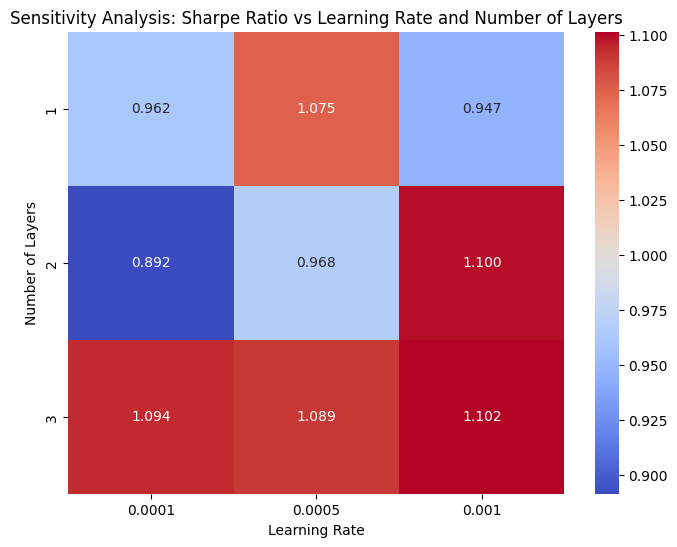

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the DataFrame to create a heatmap
heatmap_data = sensitivity_df.pivot(index='Number of Layers', columns='Learning Rate', values='Sharpe Ratio (GNN)')

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Sensitivity Analysis: Sharpe Ratio vs Learning Rate and Number of Layers')
plt.show()

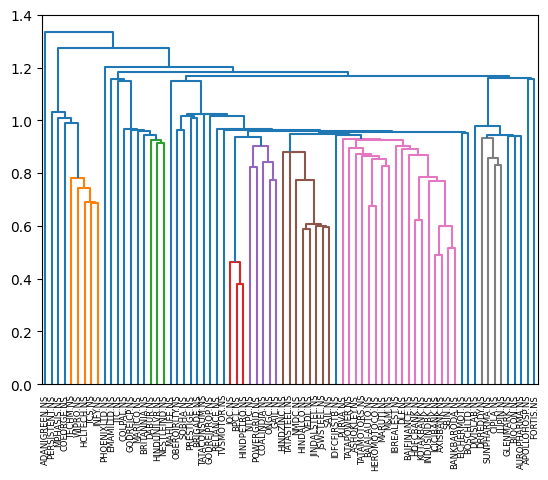

In [ ]:
  # Plot the dendrogram (optional for visualization)
import matplotlib.pyplot as plt
sch.dendrogram(linkage_matrix, labels=tickers)
plt.show()